In [1]:
from tensorflow.keras.layers import Activation, Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization, concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import numpy as np
import math
import matplotlib.pyplot as plt
import os

In [2]:
# Generator
def gen_block(x, filters = 128, kernel_size = 5, strides = 2, padding = "same"):
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding)(x)
    return x

def build_generator(inputs, labels, image_size):
  image_resize = image_size // 4
  x = concatenate([inputs, labels], axis = 1)
  x = Dense(image_resize * image_resize * 128)(inputs)
  x = Reshape((image_resize, image_resize, 128))(x)
  x = gen_block(x = x, filters = 128, kernel_size = 5, strides = 2, padding = "same")
  x = gen_block(x = x, filters = 64, kernel_size = 5, strides = 2, padding = "same")
  x = gen_block(x = x, filters = 32, kernel_size = 5, strides = 1, padding = "same")
  x = gen_block(x = x, filters = 1, kernel_size = 5, strides = 1, padding = "same")
  x = Activation('sigmoid')(x)
  generator = Model([inputs, labels], x, name = "generator")
  return generator

# Discriminator
def disc_block(x, filters = 64, kernel_size = 5, strides = 2, padding = "same"):
  x = LeakyReLU(alpha = 0.2)(x)
  x = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding)(x)
  return x

def build_discriminator(inputs, num_labels):
   x = inputs
   x = LeakyReLU(alpha = 0.2)(x)
   x = Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = "same")(x)
   x = disc_block(x = x, filters = 64, kernel_size = 5, strides = 2, padding = "same")
   x = disc_block(x = x, filters = 128, kernel_size = 5, strides = 2, padding = "same")
   x = disc_block(x = x, filters = 256, kernel_size = 5, strides = 1, padding = "same")
   x = Flatten()(x)
   x = Dense(1)(x)
   outputs = Activation("sigmoid")(x) # until here, this part estimate the prob of the input being real

   # auxiliary connection after Flatten - this part is a classifier predicting the label of the class
   layer = Dense(128)(x)
   labels = Dense(num_labels)(layer)
   labels = Activation("softmax", name = 'label')(labels)
   outputs = [outputs, labels]

   discriminator = Model(inputs, outputs, name = 'discriminator')
   return discriminator

In [3]:
(x_train, y_train), (_ , _) = mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

model_name = "acgan_mnist"
latent_size = 100 # latent vector of 100-dim
batch_size = 64
lr = 2e-4
decay = 6e-8
train_steps = 5000 # one can train for more number of steps to get better quality
input_shape = (image_size, image_size, 1)
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
label_shape = (num_labels,)

# discriminator model
inputs = Input(shape = input_shape, name = "discriminator_input")
discriminator = build_discriminator(inputs, num_labels = num_labels)
discriminator.compile(loss = ["binary_crossentropy", "categorical_crossentropy"],
                      optimizer = RMSprop(learning_rate = lr, weight_decay = decay),
                      metrics = ['accuracy'])
discriminator.summary()

# generator model
input_shape = (latent_size,)
inputs = Input(shape = input_shape, name = 'generator_input')
labels = Input(shape = label_shape, name = "labels")
generator = build_generator(inputs, labels, image_size)
generator.summary()

# adversarial model
discriminator.trainable = False
adversarial = Model([inputs, labels], discriminator(generator([inputs, labels])), name = model_name)
adversarial.compile(loss = ["binary_crossentropy", "categorical_crossentropy"],
                    optimizer = RMSprop(learning_rate = lr * 0.5, weight_decay = decay * 0.5),
                    metrics = ['accuracy'])
adversarial.summary()

11490434/11490434 [==============================] - 0s 0us/step
Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 discriminator_input (Input  [(None, 28, 28, 1)]          0         []                            
 Layer)                                                                                           
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 1)            0         ['discriminator_input[0][0]'] 
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           832       ['leaky_re_lu[0][0]']         
                                                                                                  
 leaky_re_lu_1 (Leaky

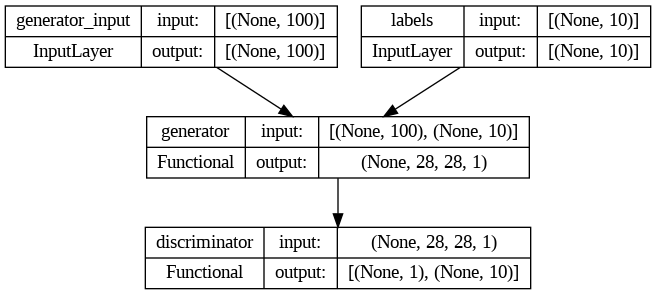

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(adversarial, show_shapes = True)

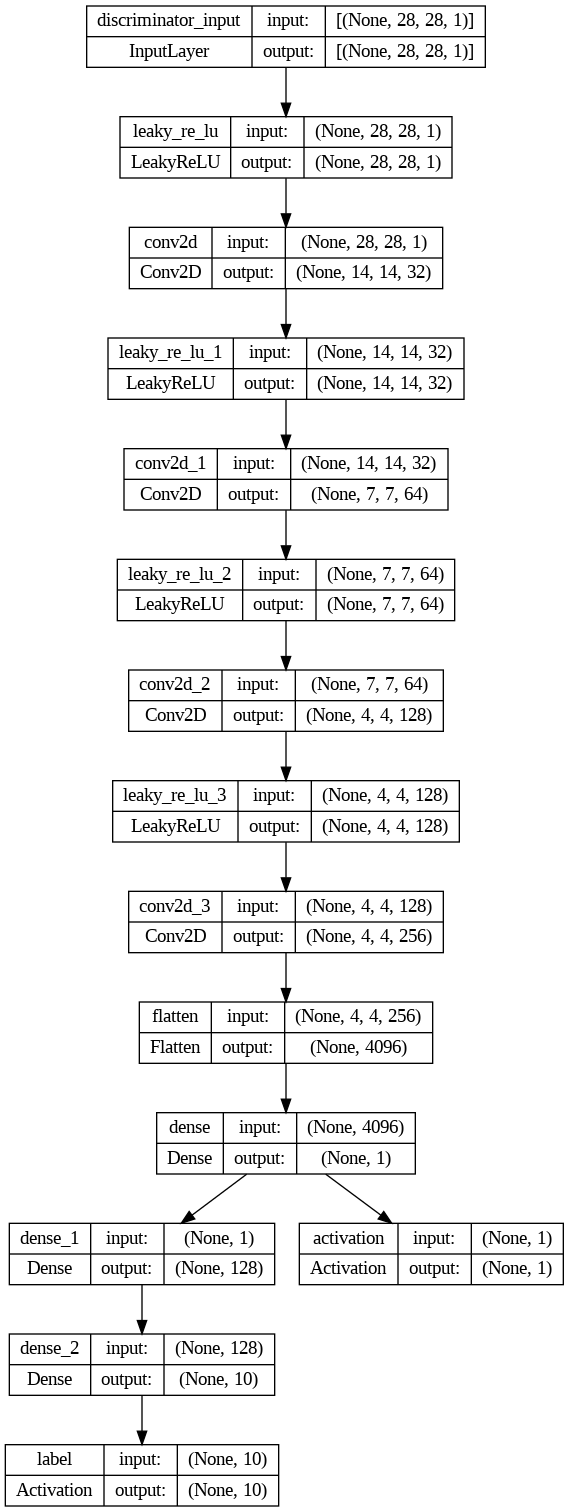

In [5]:
plot_model(discriminator, show_shapes = True)

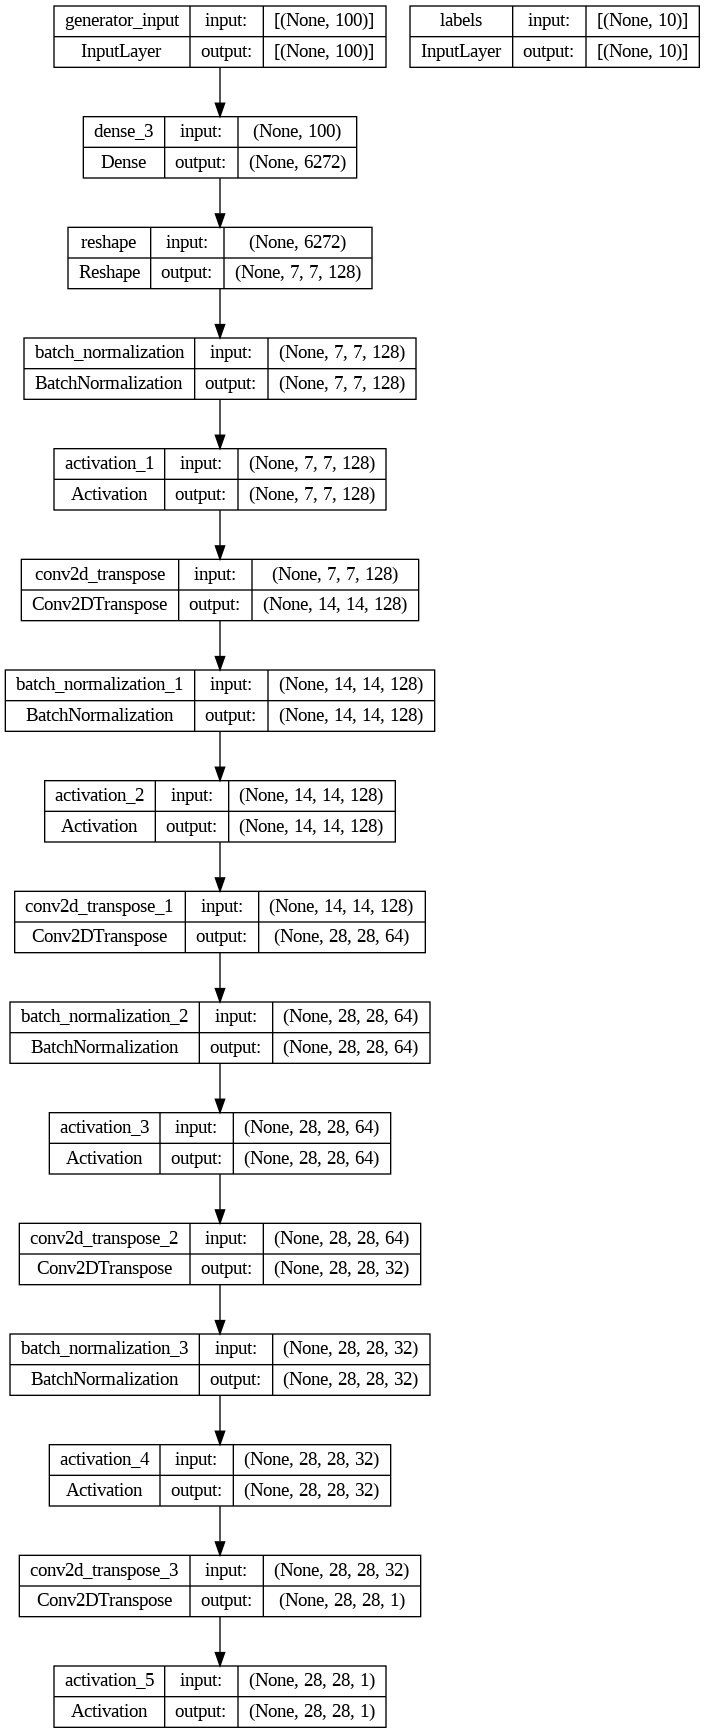

In [6]:
plot_model(generator, show_shapes = True)

In [7]:
def train(models, data, params):

  generator, discriminator, adversarial = models
  x_train, y_train = data
  batch_size, latent_size, train_steps, num_labels, model_name = params
  save_interval = 500
  noise_input = np.random.uniform(-1.0, 1.0, size = [16, latent_size])
  noise_label = np.eye(num_labels)[np.arange(0, 16) % num_labels]
  train_size = x_train.shape[0]
  print(model_name, "Labels for generated images:", np.argmax(noise_label, axis = 1))

  for i in range(train_steps):
    rand_indexes = np.random.randint(0, train_size, size = batch_size)
    real_images = x_train[rand_indexes]
    real_labels = y_train[rand_indexes]

    noise = np.random.uniform(-1.0, 1.0, size = [batch_size, latent_size])
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
    fake_images = generator.predict([noise, fake_labels])
    x = np.concatenate((real_images, fake_images))  # 1 batch of training data
    labels = np.concatenate((real_labels, fake_labels))

    y = np.ones([2 * batch_size, 1])
    y[batch_size:, :] = 0

    metrics = discriminator.train_on_batch(x, [y, labels])
    log = f"{i}: [disc loss: {metrics[0]:f}, srcloss: {metrics[1]:f}, lblloss: {metrics[2]:f}, srcacc: {metrics[3]:f}, lblacc: {metrics[4]:f}]"
    print(log)


    # train adversarial
    noise = np.random.uniform(-1.0, 1.0, size = [batch_size, latent_size])
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
    y = np.ones([batch_size, 1])
    metrics = adversarial.train_on_batch([noise, fake_labels], [y, fake_labels])
    log = f"{i}: [disc loss: {metrics[0]:f}, srcloss: {metrics[1]:f}, lblloss: {metrics[2]:f}, srcacc: {metrics[3]:f}, lblacc: {metrics[4]:f}]"
    print(log)

    if (i + 1) % save_interval == 0:
      os.makedirs(model_name, exist_ok=True)
      filename = os.path.join(model_name, f"{i + 1:05d}.png")
      images = generator.predict([noise_input, noise_label])
      plt.figure(figsize=(2.2, 2.2))
      num_images = images.shape[0]
      image_size = images.shape[1]
      rows = int(math.sqrt(noise_input.shape[0]))
      for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
      plt.savefig(filename)
      plt.show()

  generator.save(model_name + ".keras")

acgan_mnist Labels for generated images: [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
2/2 [==============================] - 0s 5ms/step
0: [disc loss: 2.435252, srcloss: 0.085025, lblloss: 2.350227, srcacc: 1.000000, lblacc: 0.171875]
0: [disc loss: 2.725789, srcloss: 0.412079, lblloss: 2.313709, srcacc: 1.000000, lblacc: 0.078125]
2/2 [==============================] - 0s 5ms/step
1: [disc loss: 2.469879, srcloss: 0.073744, lblloss: 2.396135, srcacc: 1.000000, lblacc: 0.085938]
1: [disc loss: 2.496113, srcloss: 0.160869, lblloss: 2.335243, srcacc: 1.000000, lblacc: 0.078125]
2/2 [==============================] - 0s 5ms/step
2: [disc loss: 2.461219, srcloss: 0.072724, lblloss: 2.388495, srcacc: 1.000000, lblacc: 0.148438]
2: [disc loss: 2.643709, srcloss: 0.332136, lblloss: 2.311573, srcacc: 1.000000, lblacc: 0.078125]
2/2 [==============================] - 0s 5ms/step
3: [disc loss: 2.437338, srcloss: 0.062624, lblloss: 2.374714, srcacc: 1.000000, lblacc: 0.062500]
3: [disc loss: 2.478517, src

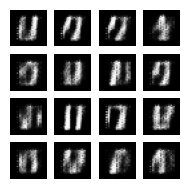

2/2 [==============================] - 0s 7ms/step
500: [disc loss: 2.756968, srcloss: 0.459683, lblloss: 2.297284, srcacc: 0.820312, lblacc: 0.132812]
500: [disc loss: 3.060830, srcloss: 0.757662, lblloss: 2.303168, srcacc: 0.453125, lblacc: 0.031250]
2/2 [==============================] - 0s 5ms/step
501: [disc loss: 2.668785, srcloss: 0.374935, lblloss: 2.293849, srcacc: 0.851562, lblacc: 0.085938]
501: [disc loss: 2.637890, srcloss: 0.315961, lblloss: 2.321929, srcacc: 0.984375, lblacc: 0.078125]
2/2 [==============================] - 0s 4ms/step
502: [disc loss: 2.685880, srcloss: 0.412894, lblloss: 2.272986, srcacc: 0.835938, lblacc: 0.164062]
502: [disc loss: 3.881750, srcloss: 1.573180, lblloss: 2.308570, srcacc: 0.015625, lblacc: 0.093750]
2/2 [==============================] - 0s 4ms/step
503: [disc loss: 2.814234, srcloss: 0.522307, lblloss: 2.291928, srcacc: 0.742188, lblacc: 0.140625]
503: [disc loss: 2.349963, srcloss: 0.010119, lblloss: 2.339844, srcacc: 1.000000, lblacc

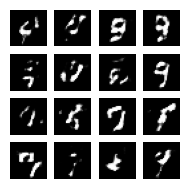

2/2 [==============================] - 0s 5ms/step
1000: [disc loss: 2.779482, srcloss: 0.524752, lblloss: 2.254731, srcacc: 0.742188, lblacc: 0.085938]
1000: [disc loss: 3.420367, srcloss: 1.096056, lblloss: 2.324311, srcacc: 0.046875, lblacc: 0.156250]
2/2 [==============================] - 0s 5ms/step
1001: [disc loss: 2.829080, srcloss: 0.561258, lblloss: 2.267822, srcacc: 0.671875, lblacc: 0.101562]
1001: [disc loss: 2.982317, srcloss: 0.666807, lblloss: 2.315510, srcacc: 0.562500, lblacc: 0.171875]
2/2 [==============================] - 0s 6ms/step
1002: [disc loss: 2.811447, srcloss: 0.601257, lblloss: 2.210190, srcacc: 0.679688, lblacc: 0.125000]
1002: [disc loss: 3.452189, srcloss: 1.150682, lblloss: 2.301507, srcacc: 0.078125, lblacc: 0.046875]
2/2 [==============================] - 0s 5ms/step
1003: [disc loss: 2.745902, srcloss: 0.545094, lblloss: 2.200809, srcacc: 0.679688, lblacc: 0.164062]
1003: [disc loss: 3.124312, srcloss: 0.807699, lblloss: 2.316613, srcacc: 0.328125

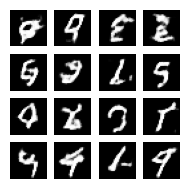

2/2 [==============================] - 0s 6ms/step
1500: [disc loss: 2.838408, srcloss: 0.555455, lblloss: 2.282952, srcacc: 0.695312, lblacc: 0.171875]
1500: [disc loss: 3.200461, srcloss: 0.779559, lblloss: 2.420902, srcacc: 0.421875, lblacc: 0.078125]
2/2 [==============================] - 0s 7ms/step
1501: [disc loss: 2.813017, srcloss: 0.562198, lblloss: 2.250819, srcacc: 0.773438, lblacc: 0.140625]
1501: [disc loss: 3.394718, srcloss: 1.011100, lblloss: 2.383618, srcacc: 0.281250, lblacc: 0.093750]
2/2 [==============================] - 0s 5ms/step
1502: [disc loss: 2.782757, srcloss: 0.557568, lblloss: 2.225190, srcacc: 0.718750, lblacc: 0.101562]
1502: [disc loss: 3.132469, srcloss: 0.805105, lblloss: 2.327364, srcacc: 0.453125, lblacc: 0.078125]
2/2 [==============================] - 0s 5ms/step
1503: [disc loss: 2.905831, srcloss: 0.646056, lblloss: 2.259775, srcacc: 0.710938, lblacc: 0.125000]
1503: [disc loss: 3.383196, srcloss: 1.054915, lblloss: 2.328281, srcacc: 0.125000

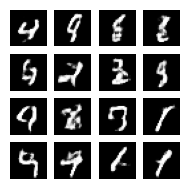

2/2 [==============================] - 0s 5ms/step
2000: [disc loss: 2.867112, srcloss: 0.567973, lblloss: 2.299139, srcacc: 0.742188, lblacc: 0.109375]
2000: [disc loss: 3.441284, srcloss: 1.070407, lblloss: 2.370878, srcacc: 0.218750, lblacc: 0.062500]
2/2 [==============================] - 0s 5ms/step
2001: [disc loss: 2.833747, srcloss: 0.542454, lblloss: 2.291293, srcacc: 0.718750, lblacc: 0.117188]
2001: [disc loss: 3.111047, srcloss: 0.807839, lblloss: 2.303208, srcacc: 0.390625, lblacc: 0.109375]
2/2 [==============================] - 0s 10ms/step
2002: [disc loss: 2.929937, srcloss: 0.658525, lblloss: 2.271412, srcacc: 0.679688, lblacc: 0.125000]
2002: [disc loss: 3.651215, srcloss: 1.250136, lblloss: 2.401079, srcacc: 0.125000, lblacc: 0.093750]
2/2 [==============================] - 0s 6ms/step
2003: [disc loss: 2.850030, srcloss: 0.585624, lblloss: 2.264407, srcacc: 0.664062, lblacc: 0.164062]
2003: [disc loss: 3.288040, srcloss: 0.954012, lblloss: 2.334028, srcacc: 0.34375

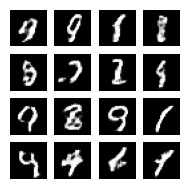

2/2 [==============================] - 0s 7ms/step
2500: [disc loss: 2.900482, srcloss: 0.617504, lblloss: 2.282979, srcacc: 0.664062, lblacc: 0.164062]
2500: [disc loss: 3.580413, srcloss: 1.255031, lblloss: 2.325382, srcacc: 0.218750, lblacc: 0.093750]
2/2 [==============================] - 0s 5ms/step
2501: [disc loss: 2.893099, srcloss: 0.564028, lblloss: 2.329070, srcacc: 0.734375, lblacc: 0.109375]
2501: [disc loss: 3.356865, srcloss: 1.016939, lblloss: 2.339927, srcacc: 0.218750, lblacc: 0.078125]
2/2 [==============================] - 0s 5ms/step
2502: [disc loss: 2.817870, srcloss: 0.530607, lblloss: 2.287263, srcacc: 0.734375, lblacc: 0.101562]
2502: [disc loss: 3.492491, srcloss: 1.187816, lblloss: 2.304675, srcacc: 0.171875, lblacc: 0.062500]
2/2 [==============================] - 0s 10ms/step
2503: [disc loss: 2.838293, srcloss: 0.558840, lblloss: 2.279453, srcacc: 0.734375, lblacc: 0.140625]
2503: [disc loss: 3.610749, srcloss: 1.310642, lblloss: 2.300107, srcacc: 0.12500

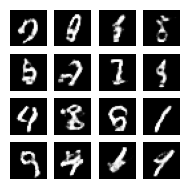

2/2 [==============================] - 0s 6ms/step
3000: [disc loss: 2.808815, srcloss: 0.522597, lblloss: 2.286218, srcacc: 0.742188, lblacc: 0.140625]
3000: [disc loss: 3.148401, srcloss: 0.842708, lblloss: 2.305694, srcacc: 0.468750, lblacc: 0.046875]
2/2 [==============================] - 0s 5ms/step
3001: [disc loss: 2.818325, srcloss: 0.552451, lblloss: 2.265873, srcacc: 0.710938, lblacc: 0.164062]
3001: [disc loss: 3.833077, srcloss: 1.487960, lblloss: 2.345117, srcacc: 0.156250, lblacc: 0.109375]
2/2 [==============================] - 0s 5ms/step
3002: [disc loss: 2.870175, srcloss: 0.627824, lblloss: 2.242352, srcacc: 0.703125, lblacc: 0.171875]
3002: [disc loss: 3.180485, srcloss: 0.892100, lblloss: 2.288384, srcacc: 0.375000, lblacc: 0.109375]
2/2 [==============================] - 0s 5ms/step
3003: [disc loss: 2.828403, srcloss: 0.571403, lblloss: 2.256999, srcacc: 0.695312, lblacc: 0.195312]
3003: [disc loss: 3.368859, srcloss: 1.032265, lblloss: 2.336595, srcacc: 0.312500

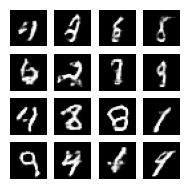

2/2 [==============================] - 0s 5ms/step
3500: [disc loss: 2.986916, srcloss: 0.664676, lblloss: 2.322240, srcacc: 0.632812, lblacc: 0.132812]
3500: [disc loss: 3.147871, srcloss: 0.840271, lblloss: 2.307600, srcacc: 0.484375, lblacc: 0.109375]
2/2 [==============================] - 0s 5ms/step
3501: [disc loss: 2.766101, srcloss: 0.505508, lblloss: 2.260593, srcacc: 0.773438, lblacc: 0.093750]
3501: [disc loss: 3.820271, srcloss: 1.512877, lblloss: 2.307395, srcacc: 0.078125, lblacc: 0.171875]
2/2 [==============================] - 0s 5ms/step
3502: [disc loss: 2.839247, srcloss: 0.568826, lblloss: 2.270421, srcacc: 0.687500, lblacc: 0.148438]
3502: [disc loss: 3.222207, srcloss: 0.867519, lblloss: 2.354687, srcacc: 0.421875, lblacc: 0.062500]
2/2 [==============================] - 0s 5ms/step
3503: [disc loss: 2.834182, srcloss: 0.517211, lblloss: 2.316971, srcacc: 0.718750, lblacc: 0.101562]
3503: [disc loss: 3.807133, srcloss: 1.475458, lblloss: 2.331675, srcacc: 0.093750

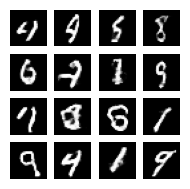

2/2 [==============================] - 0s 12ms/step
4000: [disc loss: 2.832138, srcloss: 0.557630, lblloss: 2.274508, srcacc: 0.726562, lblacc: 0.148438]
4000: [disc loss: 3.577287, srcloss: 1.268904, lblloss: 2.308384, srcacc: 0.218750, lblacc: 0.062500]
2/2 [==============================] - 0s 5ms/step
4001: [disc loss: 2.859012, srcloss: 0.556215, lblloss: 2.302796, srcacc: 0.710938, lblacc: 0.093750]
4001: [disc loss: 3.197595, srcloss: 0.854681, lblloss: 2.342914, srcacc: 0.421875, lblacc: 0.046875]
2/2 [==============================] - 0s 5ms/step
4002: [disc loss: 2.982163, srcloss: 0.669212, lblloss: 2.312952, srcacc: 0.632812, lblacc: 0.101562]
4002: [disc loss: 3.703257, srcloss: 1.357423, lblloss: 2.345834, srcacc: 0.187500, lblacc: 0.078125]
2/2 [==============================] - 0s 5ms/step
4003: [disc loss: 2.918091, srcloss: 0.632750, lblloss: 2.285342, srcacc: 0.687500, lblacc: 0.148438]
4003: [disc loss: 3.349372, srcloss: 1.022943, lblloss: 2.326428, srcacc: 0.28125

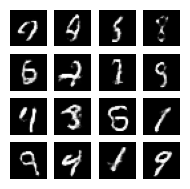

2/2 [==============================] - 0s 5ms/step
4500: [disc loss: 2.836391, srcloss: 0.550774, lblloss: 2.285618, srcacc: 0.734375, lblacc: 0.101562]
4500: [disc loss: 3.140474, srcloss: 0.839547, lblloss: 2.300927, srcacc: 0.437500, lblacc: 0.062500]
2/2 [==============================] - 0s 11ms/step
4501: [disc loss: 2.818123, srcloss: 0.528211, lblloss: 2.289912, srcacc: 0.710938, lblacc: 0.101562]
4501: [disc loss: 3.386461, srcloss: 1.105448, lblloss: 2.281012, srcacc: 0.171875, lblacc: 0.109375]
2/2 [==============================] - 0s 5ms/step
4502: [disc loss: 2.789950, srcloss: 0.513692, lblloss: 2.276258, srcacc: 0.750000, lblacc: 0.148438]
4502: [disc loss: 3.238926, srcloss: 0.946170, lblloss: 2.292756, srcacc: 0.296875, lblacc: 0.093750]
2/2 [==============================] - 0s 5ms/step
4503: [disc loss: 2.763222, srcloss: 0.491366, lblloss: 2.271856, srcacc: 0.765625, lblacc: 0.117188]
4503: [disc loss: 3.791208, srcloss: 1.463951, lblloss: 2.327256, srcacc: 0.12500

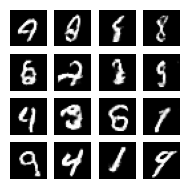

In [9]:
models = (generator, discriminator, adversarial)
data = (x_train, y_train)
params = (batch_size, latent_size, train_steps, num_labels, model_name)
train(models, data, params)

In [19]:
import matplotlib.image as mpimg
def load_images(image_dir):
    images = []
    filenames = os.listdir(image_dir)
    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        img = mpimg.imread(img_path)
        images.append(img)
    return images

def plot_images_in_grid(images, grid_shape):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

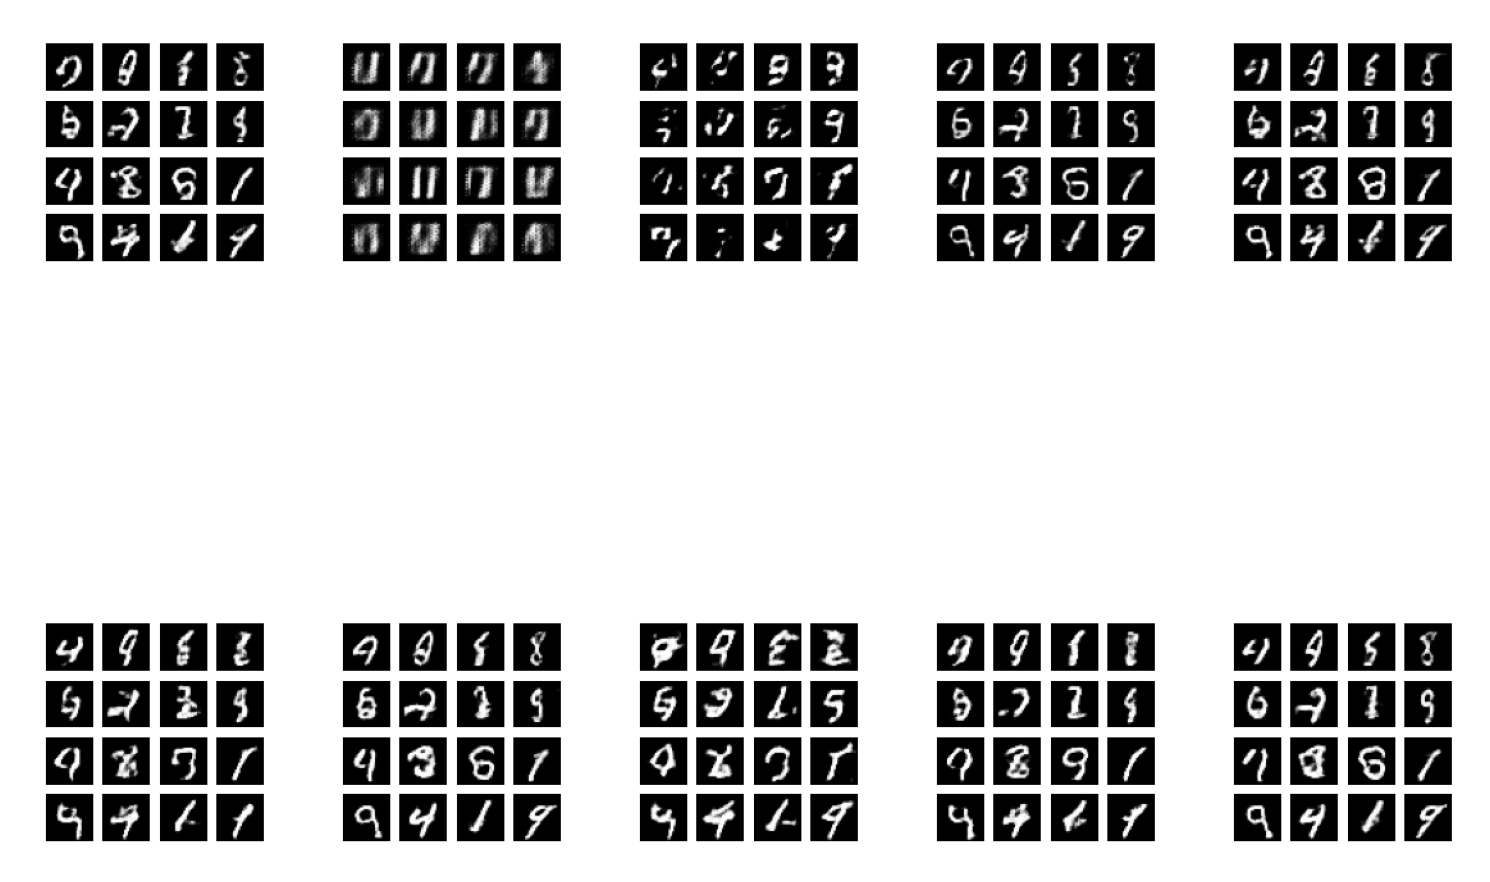

In [21]:
image_dir = '/content/acgan_mnist/'
images = load_images(image_dir)
plot_images_in_grid(images, (2, 5))